In [1]:
# --- Importar librerias --- #
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops

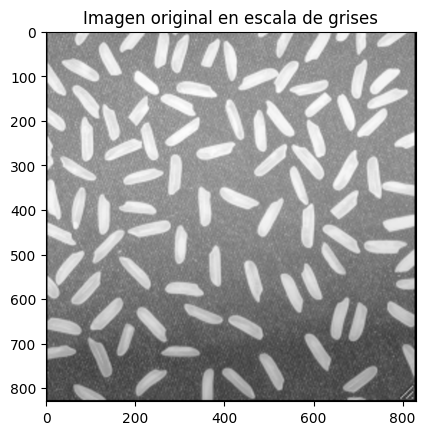

In [18]:
# --- Cargar la imagen y binarizarla --- #
im = cv2.imread('rice.png', cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.imshow(im, cmap='gray')
plt.title("Imagen original en escala de grises")
plt.show()

# Características cromáticas

## Color Promedio

In [5]:
color_promedio = np.mean(im)
print(f"Color promedio de la imagen completa: {color_promedio:.2f}")

Color promedio de la imagen completa: 126.48


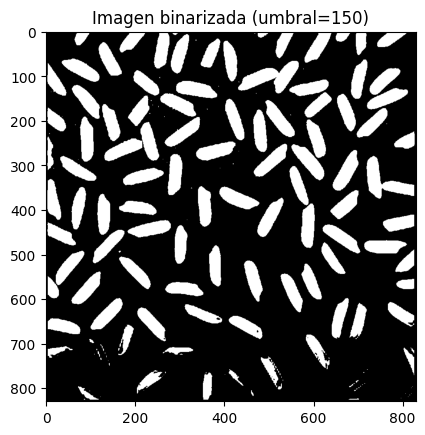

In [7]:
# --- Binarizacion de la imagen ---
_, bw = cv2.threshold(im, 150, 255, cv2.THRESH_BINARY) # Umbral de 150

plt.imshow(bw, cmap='gray')
plt.title('Imagen binarizada (umbral=150)')
plt.show()

## Gradiente Promedio, Constrate y Momentos de Hu

### Etiquetar los objetos

In [8]:
label_img = label(bw)
props = regionprops(label_img, intensity_image=im)
print(f"Se detectaron {len(props)} granos de arroz.")

Se detectaron 183 granos de arroz.


### Calculo de valores

In [27]:
data = [] # Inicializar lista con los resultados

'''
 Calcular Sobel sobre la imagen para
 luego promediar solo las magnitudes
 de los píxeles que pertenecen al grano
 y asi obtener el gradiente de intensidad real.
'''

gx = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=3)
mag = np.sqrt(gx**2 + gy**2)

for i, region in enumerate(props):
    # Máscara de la región
    region_mask = (label_img == region.label).astype(np.uint8)

    # --- Gradiente promedio para cada grano ---
    gradiente = np.mean(mag[region_mask == 1])

    # --- Contraste (desviación estándar de intensidades dentro de la región) ---
    intensidades = im[region_mask == 1]

    # Se calcula la desviación estándar de las intensidades dentro del grano
    contraste = np.std(intensidades)

    # --- Momentos de Hu en escala de grises ---
    region_gray = im * region_mask  # Valores en escala de grises del grano
    momentos = cv2.moments(region_gray.astype(np.uint8))
    hu = cv2.HuMoments(momentos).flatten()[:4]

    # Normalización logarítmica para evitar valores extremadamente pequeños
    hu_norm = [-1 * np.sign(h) * np.log10(abs(h)) if h != 0 else 0 for h in hu]

    # Guardar datos
    data.append({
        "Grano": i+1,
        "GradienteProm": gradiente,
        "Contraste": contraste,
        "Hu1": hu_norm[0],
        "Hu2": hu_norm[1],
        "Hu3": hu_norm[2],
        "Hu4": hu_norm[3]
    })

df = pd.DataFrame(data)
print("\n=== Descriptores extraídos por grano de arroz ===")
display(df.head(50)) # Mostrar los resultados para los primeros 50 granos


=== Descriptores extraídos por grano de arroz ===


,Grano,GradienteProm,Contraste,Hu1,Hu2,Hu3,Hu4
0,1,65.472354,11.992145,3.015080,6.851627,9.813459,11.105199
1,2,51.054130,13.083677,2.945464,6.220611,10.553801,11.737552
2,3,104.993948,16.112557,2.931219,6.252177,9.400032,10.022209
3,4,48.203911,12.740469,2.905621,6.094804,9.793411,10.740489
4,5,42.336715,13.816165,2.890832,5.996077,11.009927,11.676937
5,6,93.588627,17.185044,3.045734,6.835824,10.200782,11.179200
6,7,59.325181,14.460187,2.964039,6.327706,10.112974,10.822674
7,8,48.967567,12.022433,2.891111,6.033560,9.821755,10.229696
8,9,42.138457,13.211943,2.873645,5.946548,11.192567,11.928844
9,10,123.091540,12.903554,2.891305,6.167354,9.281191,10.444882


## Análisis de los resultados



Los descriptores extraídos muestran diferencias claras entre los granos de arroz tanto en su textura como en su forma. El gradiente promedio, con valores que varían entre aproximadamente 42 y 123, indica el nivel de cambio de intensidad dentro de cada grano, donde los granos con valores más altos (por ejemplo, el grano 10 con 123.09) presentan bordes más definidos o variaciones de iluminación más marcadas, mientras que los de menor gradiente poseen una superficie más homogénea. En cuanto al contraste, cuyos valores oscilan entre *3.11* y *17.18*, se observa que los granos con mayor contraste corresponden a regiones donde la textura interna es más variable, posiblemente debido a sombras o diferencias en la iluminación.

Los momentos de Hu normalizados reflejan la forma y simetría de cada grano. Los momentos Hu1 y Hu2, por ejemplo, podrian asociarse con la elongación y la distribución de masa, por lo que valores similares entre granos sugieren formas alargadas y regulares, típico de un arroz.